In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits, ascii
from astropy.table import QTable

from astropy import units as u
from synphot import units

from astropy.stats import mad_std, sigma_clipped_stats
from scipy.stats import binned_statistic
from scipy.interpolate import UnivariateSpline

## Synthetic Photometry of AGN Optical Spectra

This code calculates synthetic photometry for SDSS spectra using ten box filters that are evenly distributed between 3900 and 9100 Angstroms<br>


In [2]:
# Line-free wavelengths as selected by eye from composite SDSS quasar spectra
# Vanden Berk et al. (2001) doi:10.1086/321167

lambdas_rest = np.array([1286,1327,1355,1449,1594,1695,1800,1976,2030,2127,2200,2243,2652,2903,3024,3091,3152,3320,
                         3546,3623,3689,3800,3933,3989,4011,4030,4203,4445,4730,5087,5407,5482,5596,5668,5984,6026,
                         6156,6222,6759,6846,6900,7200,7400,7500,7800,8100,8400,8700,9000])*u.AA

In [3]:
# Defining the names and number of filters to perform synthetic photometry and their combined wavelength span
n_filters = 10
filter_names = ['SDSS_1', 'SDSS_2', 'SDSS_3', 'SDSS_4', 'SDSS_5', 'SDSS_6', 'SDSS_7', 'SDSS_8', 'SDSS_9', 'SDSS_10']
low_end, high_end = 3900*u.AA, 9100*u.AA

This code works only within the redshift range:

In [4]:
z_min = np.round(((high_end/np.nanmax(lambdas_rest))-1),4)
z_max = np.round(((low_end/np.nanmin(lambdas_rest))-1),4)
print('z_min =',z_min,' z_max =',z_max)

z_min = 0.0111  z_max = 2.0327


If your redshift is outside this range, you need to include more rest frame wavelenghts whith no AGN emission lines as seen in the composite SDSS quasar spectra to the list <code>lambdas_rest</code> to account for your redshift range.

In [5]:
# Getting the id, redshift and fits filename of the source

agn = QTable.read('sample_data.txt',format='ascii')
z = agn['z'][0]
filename = agn['specfile'][0]
id_name = agn['id'][0]
print(agn)

        id           z              specfile        
----------------- -------- -------------------------
70364629599017726 0.500867 spec-1290-52734-0525.fits


In [7]:
def get_spectra(filename, lambdas_rest, z):
 
    # Save wavelenghts and fluxes getting rid of the noisy first and last 100 Angstroms

    with fits.open(filename) as f:
        spectra = f[1].data
        info = f[2].data
    hdul = fits.open(filename)

    wavemin, wavemax = (info['WAVEMIN']+100)*u.AA, (info['WAVEMAX']-100)*u.AA

    spectra_wave_bfcut = ( spectra['loglam'] * u.dex(u.AA) ).to(u.AA)
    spectra_flux_bfcut = ( spectra['flux'] * units.FLAM * u.Unit(1e-17) ).to(units.FLAM)

    cut_spectra = ( (spectra_wave_bfcut>wavemin) & (spectra_wave_bfcut<wavemax) )

    spectra_wave_obs = spectra_wave_bfcut[ cut_spectra ]
    spectra_flux = spectra_flux_bfcut[ cut_spectra ]
    
    # Select the line-free wavelengths that fall withing the redshifted wavelenght range

    lambdas_obs = lambdas_rest * (1+z)

    cut_mylambdas = ( (lambdas_obs > wavemin) & (lambdas_obs < wavemax) )

    mylambdas_obs = lambdas_obs[ cut_mylambdas ]
        
    return spectra_wave_obs, spectra_flux, mylambdas_obs

In [8]:
wavelengths, fluxes, linefree_lambdas = get_spectra(filename,lambdas_rest,z)

Text(0, 0.5, 'Flux [$\\mathrm{erg~s^{-1}~cm^{-2}~\\mathring{A}^{-1}}$]')

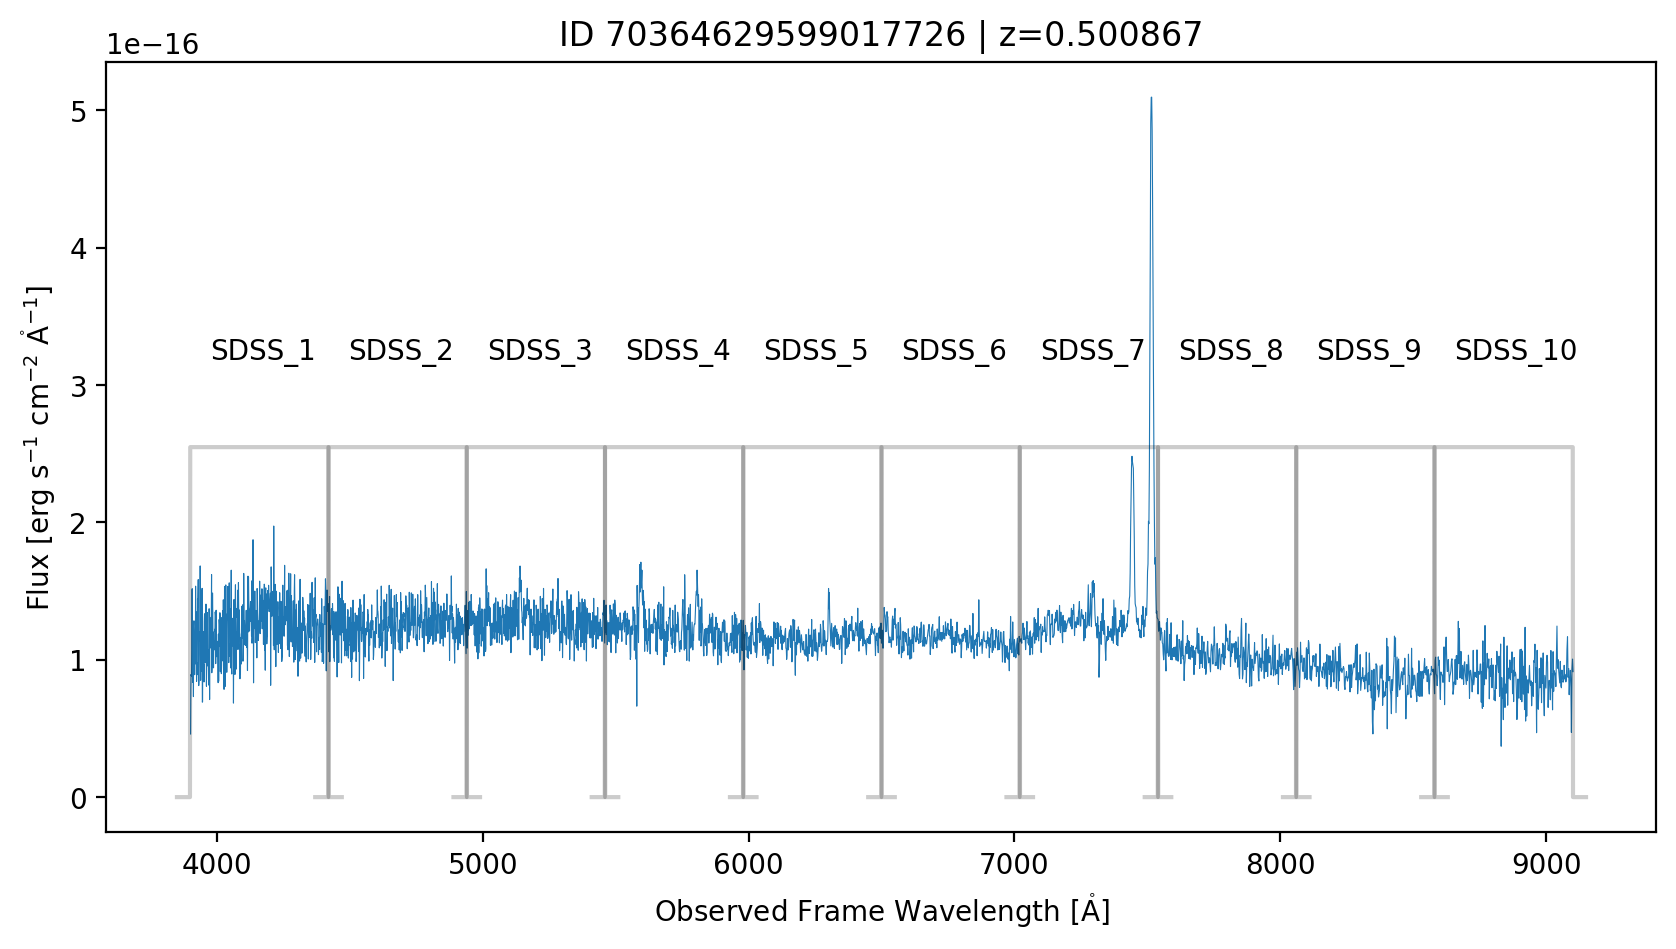

In [9]:
# Show the coverage of box filters
fake_filter_names = ['SDSS_1', 'SDSS_2', 'SDSS_3', 'SDSS_4', 'SDSS_5', 'SDSS_6', 'SDSS_7', 'SDSS_8', 'SDSS_9', 'SDSS_10']

plt.figure(figsize=(10,5), dpi=200)
plt.plot(wavelengths, fluxes, lw = .4)
for filter_name in fake_filter_names:
    flter = ascii.read("Filters/fake_filters/"+filter_name+".dat", names = ["wavelength", "transmission"])
    plt.plot(flter["wavelength"], flter["transmission"]*np.nanmax(fluxes)/2, c = "k", alpha=0.2)
    plt.text(np.nanmin(flter["wavelength"])+125, np.nanmax(flter["transmission"]*np.nanmax(fluxes)).value/1.6, 
             filter_name)
plt.title('ID '+str(id_name)+' | z='+str(z))
plt.xlabel(r'Observed Frame Wavelength [$\mathrm{\mathring{A}}$]')
plt.ylabel(r'Flux [$\mathrm{erg~s^{-1}~cm^{-2}~\mathring{A}^{-1}}$]')

In [10]:
# Make a spline fit across the line-free wavelenths to get the AGN continuum emission

n_spline = 500 # Choose how many iterations of spline fitting you want to do

def synth_photometry(spectra_wave_obs, spectra_flux, mylambdas_obs):
    
    # Randomly select neighboring values of the line-free wavelengths within +/- 10 Angstroms
    # to produce an array of spline fits and get an estimation of the uncertainty in synthetic fluxes
    
    rands = (np.random.random((n_spline, len(mylambdas_obs))) - 0.5) * 20 * u.AA

    synth_fluxes = [] # Array to store synthetic fluxes at each box filter across all iterations of spline fits
    
    for k in range(n_spline):

        mylambdas_rand = mylambdas_obs + rands[k]

        # Store the robust-mean flux within +/- 15 Angstroms of every line-free wavelength
        myfluxes_rand = []
        for element in mylambdas_rand:
            wave_up = element+(15*u.AA)
            wave_dw = element-(15*u.AA)
            cut_myflux = ( (spectra_wave_obs>wave_dw) & (spectra_wave_obs<wave_up) )
            flux_range = spectra_flux[ cut_myflux ]
            range_mean = sigma_clipped_stats(flux_range, sigma=3, stdfunc=mad_std)[0]
            myfluxes_rand.append(range_mean.value)
        myfluxes_rand = np.array(myfluxes_rand)*units.FLAM

        spl = UnivariateSpline(mylambdas_rand,myfluxes_rand, k=5) # Spline fit across the line-free wavelengths

        # Obtain the mean flux in each of the n-box-filters
        bin_means, bin_edges, binnumber = binned_statistic( spectra_wave_obs,spl(spectra_wave_obs), 
                                            statistic='mean', bins=n_filters, range=(low_end.value,high_end.value) )
        
        synth_fluxes.append(bin_means) # Storing the filter fluxes for each iteration of spline fits 

    synth_fluxes = np.array(synth_fluxes)*units.FLAM

    #   Collapsing the flux values from all spline fits into a set of n-filter fluxes
    best_flux = np.mean(synth_fluxes, axis=0)
    best_flux_err = np.std(synth_fluxes, axis=0)

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2    
    best_wave = np.array(bin_centers)*u.AA # array to store the effective wavelength of each filter

    #   Calculating the Poisson Noise in each filter bin
    sigma_filters = []
    for n in range(n_filters):
        cut_filter = ( (spectra_wave_obs>=bin_edges[n]*u.AA) & (spectra_wave_obs<bin_edges[n+1]*u.AA) )
        filter_flux = spectra_flux[ cut_filter ]
        residuals = filter_flux - best_flux[n]
        sigma_robust = sigma_clipped_stats(np.abs(residuals), sigma=5, stdfunc=mad_std)[0]
        sigma_filters.append(sigma_robust.value)
    sigma_filters = np.array(sigma_filters)*units.FLAM

    # Combining stdv error of each filter flux across spline fit iterations and poisson noise error in each filter 
    errors = np.sqrt(best_flux_err**2+sigma_filters**2)
    
    return best_flux, errors, best_wave


In [11]:
filter_fluxes, sigmas, eff_wavelengths = synth_photometry(wavelengths,fluxes,linefree_lambdas)

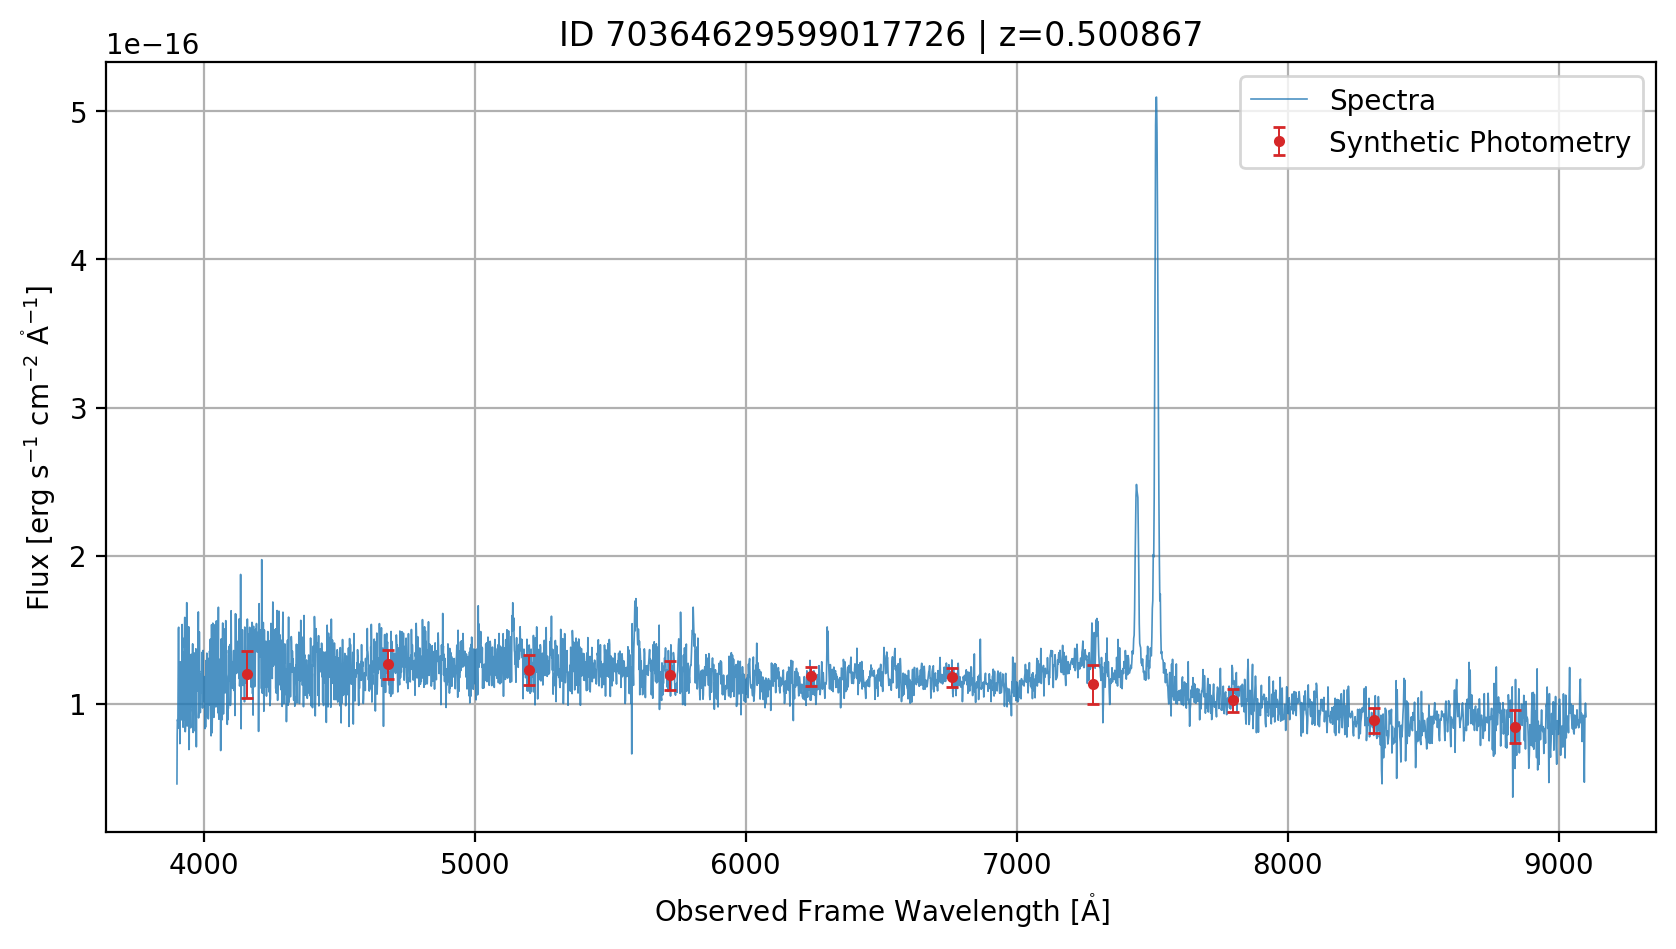

In [12]:
# Plotting the spectra with synthetic photometry
plt.figure(figsize=(10,5), dpi=200)

plt.plot( wavelengths, fluxes, label='Spectra', lw='.6', alpha=0.8)
plt.errorbar(eff_wavelengths, filter_fluxes, yerr=sigmas, label='Synthetic Photometry', color='tab:red', fmt='.', 
             elinewidth=0.7, capsize=2)
plt.title('ID '+str(id_name)+' | z='+str(z))
plt.xlabel(r'Observed Frame Wavelength [$\mathrm{\mathring{A}}$]')
plt.ylabel(r'Flux [$\mathrm{erg~s^{-1}~cm^{-2}~\mathring{A}^{-1}}$]')
plt.grid()
plt.legend()

# Filters

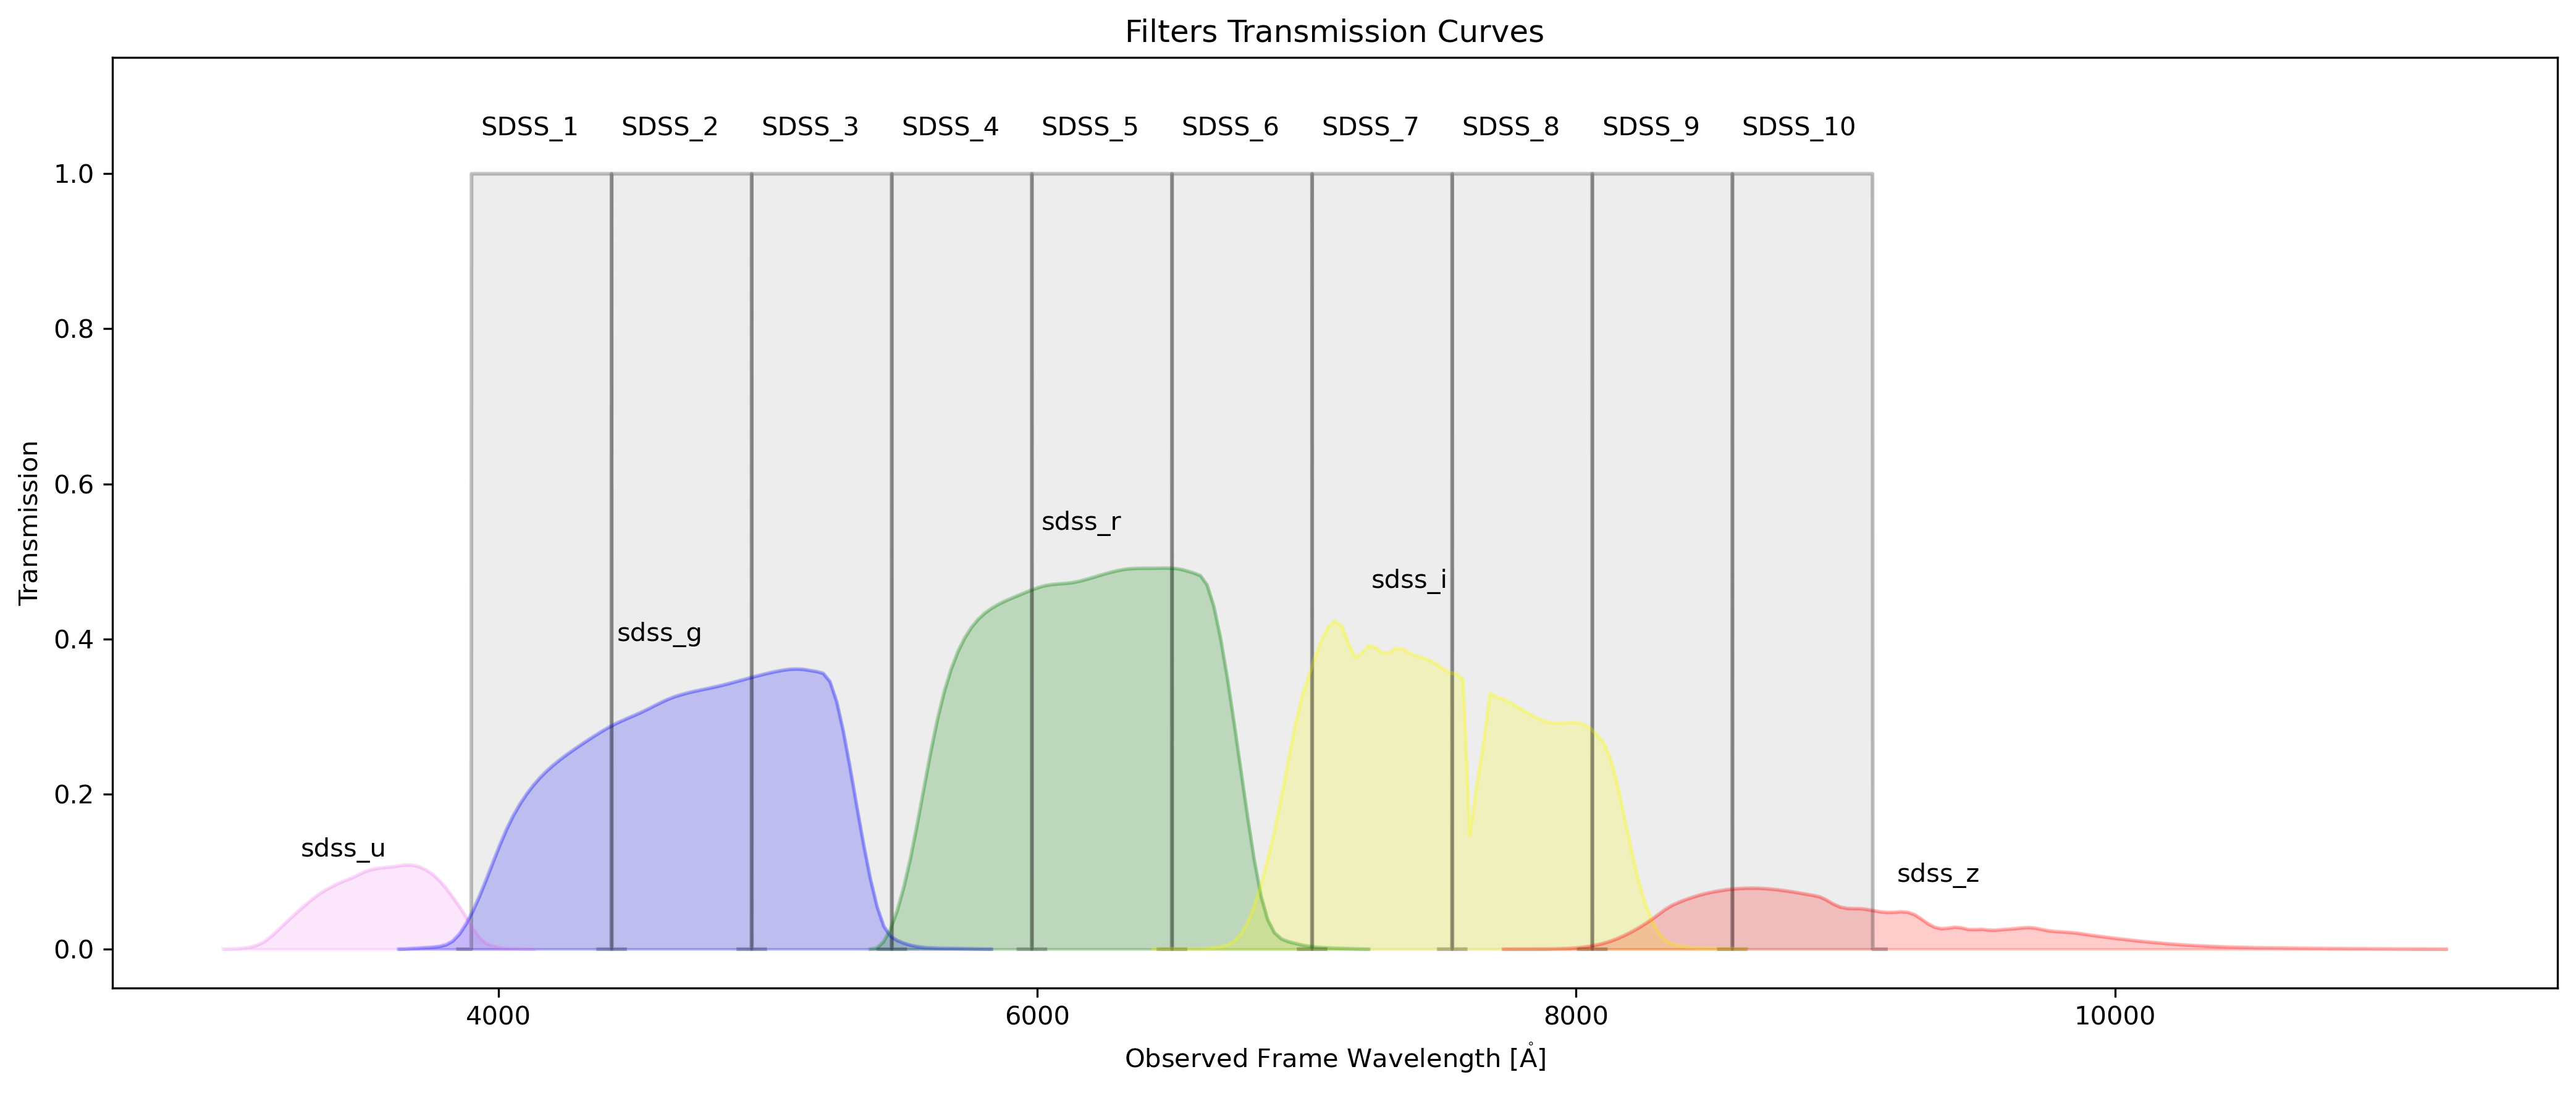

In [13]:
# Show the coverage of box filters
fake_filter_names = ['SDSS_1', 'SDSS_2', 'SDSS_3', 'SDSS_4', 'SDSS_5', 'SDSS_6', 'SDSS_7', 'SDSS_8', 'SDSS_9', 'SDSS_10']
filter_names = ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']
colors = ['violet', 'blue', 'green', 'yellow', 'red']

plt.figure(figsize=(14,6), dpi=300)
for filter_name in fake_filter_names:
    flter = ascii.read("Filters/fake_filters/"+filter_name+".dat", names = ["wavelength", "transmission"])
    plt.plot(flter["wavelength"], flter["transmission"], c = "k", alpha=0.2)
    plt.fill_between(flter["wavelength"], flter["transmission"], color='k', alpha=0.07)
    plt.text(np.nanmin(flter["wavelength"])+85, np.nanmax(flter["transmission"])*1.05, 
             filter_name, fontsize=10)
for i in range(len(filter_names)):
    flter = ascii.read("Filters/"+filter_names[i]+".txt", names = ["wavelength", "transmission"])
    plt.plot(flter["wavelength"], flter["transmission"], c = colors[i], alpha=0.2)
    plt.fill_between(flter["wavelength"], flter["transmission"], color=colors[i], alpha=0.2)
    plt.text(np.nanmean(flter["wavelength"])-290, np.nanmax(flter["transmission"])*1.1, 
             filter_names[i])
plt.title('Filters Transmission Curves')
plt.xlabel(r'Observed Frame Wavelength [$\mathrm{\mathring{A}}$]')
plt.ylabel('Transmission')
plt.ylim(top=1.15)
plt.tight_layout()

# plt.savefig('/Users/mm5382/Documents/Research/AGN_Research/Type1_sample/Plots/filter_transmission_curves.png')